In [21]:
import numpy as np
from cvxopt import solvers, matrix, sparse
import matplotlib.pyplot as plt
#from scipy import sparse
%matplotlib inline
import sys, os
old_stdout = sys.stdout 
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
# Restore
def enablePrint():
    sys.stdout = old_stdout


In [200]:
'''
The function 'obstacleqp' solves the obstacle problem on the box [a,b] x [a,b] with data -A, P, and F, where A is the 
Poission matrix, P is the height of the obstacle at each gridpoint defined by the function psi(x,y), and F is the 
force on the membrane at each gridpoint defined by the function f(x,y). The function f2 defines the boundary conditions
on the box [a,b] x [a,b].

The function 'obstacle2D' dicretizes the fucntion data passed to 'obstacleqp.' It takes the same arguments as
'obstacleqp,' and returns the 1D vector X of gridpoints on [a,b], the Poisson matrix A, the vectors P and F described
above, and the vector of initial conditions A. The initial conditions are subtracted from the vector F, and it is this
F that 'obstacle2D' returns.
'''
def obstacle2D(psi,m,f,f2,a = -2.0,b = 2.0):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(a + 4*h,b - 4*h,m)
    A = np.zeros((N,N))
    F = np.zeros((N,1))
    P = np.zeros((N,1))
    Uk = np.zeros((N,1))
    T = np.zeros((m,m))
    I = np.identity(m)
    F2 = np.zeros((N,1))
    for i in range(1,m-1):
        T[i,i] = -4.0
        T[i,i-1] = 1.0
        T[i,i+1] = 1.0
    T[0,0] = -4.0
    T[0,1] = 1.0
    T[-1,-2] = 1.0
    T[-1,-1] = -4.0
    for i in range(1,m-1):
        A[i*m:(i+1)*m,i*m:(i+1)*m] = T
        A[i*m:(i+1)*m,(i+1)*m:m*(i+2)] = I
        A[i*m:(i+1)*m,m*(i-1):i*m] = I
    A[0:m,0:m] = T
    A[0:m,m:2*m] = I
    A[m*(m-1):N,m*(m-2):m*(m-1)] = I
    A[m*(m-1):N,m*(m-1):N] = T
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            P[k] = psi(X[i],X[j])
            Uk[k] = max(P[k],0.0)
            if j == 0:
                F2[k] = F2[k] + f2(X[i],a)
            if j == m - 1:
                F2[k] = F2[k] + f2(X[i],b)
            if i%m == 0:
                F2[k] = F2[k] + f2(a,X[j])
            if (i + 1)%m == 0:
                F2[k] = F2[k] + f2(b,X[j])
    F = F - F2
    return A, Uk, P, F, X

def obstacleqp(psi, m, f, f2, a = 0, b = 0):
  N = m**2
  A, Uk, P, F, X = obstacle2D(psi, m, f, f2)
  plt.spy(A)
  sol = solvers.qp(matrix(-A),matrix(F),matrix(-np.identity(N)),matrix(-P),initvals = matrix(Uk))
  U = sol['x']
  enablePrint()
  return X, U

Alpha = .68026
Beta = .47152
f = lambda x,y: x*0
f2 = lambda: x,y: -Alpha*np.log(np.sqrt(x**2 + y**2)) + Beta
psi = lambda x,y: np.sqrt(np.maximum(0.0,1 - x**2 - y**2)) + np.minimum(0.0,1-x**2-y**2)
# = lambda x,y: 5 - np.sin(14*x)# - np.sin(14*y)

[[-0.44485108]
 [-0.2091126 ]
 [-0.19584599]
 ..., 
 [-0.19584599]
 [-0.2091126 ]
 [-0.44485108]]
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -3.8207e+03  2e+03  8e-01  3e+01
 1:  3.3662e+01 -2.1793e+03  2e+03  4e-01  2e+01
 2:  3.0171e+01 -5.9335e+02  6e+02  1e-01  5e+00
 3:  9.6708e+00 -1.1673e+02  1e+02  2e-02  9e-01
 4:  3.4747e+00 -2.5645e+00  6e+00  2e-04  8e-03
 5:  8.8418e-01  4.7322e-01  4e-01  2e-06  8e-05
 6:  7.2100e-01  6.6480e-01  6e-02  2e-07  8e-06
 7:  7.0848e-01  6.9932e-01  9e-03  2e-08  9e-07
 8:  7.0710e-01  7.0635e-01  7e-04  1e-09  5e-08
 9:  7.0700e-01  7.0698e-01  2e-05  2e-11  8e-10
10:  7.0700e-01  7.0700e-01  4e-07  2e-13  9e-12
Optimal solution found.


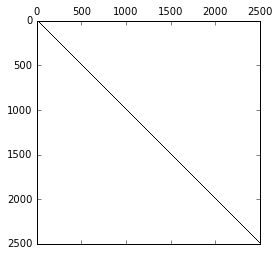

In [201]:
m = 50
h = 1/(m+1)
enablePrint()
X, U1 = obstacleqp(psi, m, f, f2)

#print(U1)

norm = [ 0.00110906] 1234
0.705959462906
0.724616258987
0.715287860946


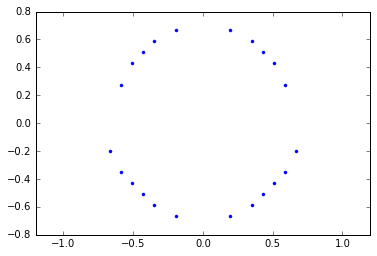

In [210]:
m = 50
h = 1/(m+1)
X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
A,B = np.meshgrid(X,X)
C = psi(A,B)
N = m**2
Z = np.zeros((m,m))
Z1 = Z
'''
Z is the numerically approximated solution vector U1 converted into a 2D form for plotting; Z1 is the exact solution
converted into a 2D form.
'''
uexact = np.zeros((N,1))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U1[kk(i,j)]
        if r > .69797: #if (X[i], X[j]) is outside the contact region
            uexact[kk(i,j)] = f2(X[i],X[j])
        else:
            uexact[kk(i,j)] = psi(X[i],X[j])
        Z1[i,j] = uexact[kk(i,j)]
print('||U - uexact||_inf =',max(list(abs(uexact - U1))))
x = []
y = []
z = []
'''
The code below builds vectors containing coordinates for the contact set.
'''
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal')
'''
This function approximates the area of the circular contact set using trapezoids. 
'''
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    '''
    The loop below removes points that add extra edges to the contact region, making it less circular.
    '''
    while j < len(x1): 
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    #for i in range(0,1000):
    rmax = max(normlist)
    return x1, y1, z1, A, rmax #returns both the area and the maximum radial distance of any point in the computed
    #contact set. Both provide decent apporximations of the boundary for the contact set.
x1, y1, z1, A1, rmax = area(x,y,z,m)
plt.plot(x1,y1,'.')
plt.axis('equal') 

'''
Here we repeat the same area computation, but decrease the tolerance for the contact set. The problem inherent in 
approximating the contact set is that the points that we compute to be in the contact set are not on the 
boundary. Hence the maximum magnitude of any point in the contact set is less than the true radius. It may be that 
reducing the tolerance provides a better estimate of the contact set. Here we use the average of the two computed 
values for the approximation, but it doesn't really matter -- any of the three values could be the closest to the 
true radius on any given (radial) problem.
'''

x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-2:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
x2, y2, z2, A2, rmax2 = area(x,y,z,m)
'''
A few different estimates of the contact set radius. All are overestimates, with the area method being the most 
accurate.
'''
a = np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)])
b = np.mean([rmax,rmax2])
print(np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)]))
print(np.mean([rmax,rmax2]))
print(np.mean([a,b]))



(-2, 2)

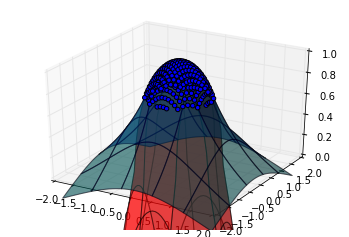

In [217]:
from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf3 = ax.plot_surface(A,B,Z,color = 'g',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z1,vmin = 0.0, vmax = 5.1, alpha = .2)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(0,1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)


In [203]:
def reducedspace2(psi,m,f,f2,a = -2.0,b = 2.0):
    A, Uk, P, F, X = obstacle2D(psi,m,f,f2)
    L = lambda U: np.dot(-A,U + P) + F
    dL = lambda U: -A
    enablePrint()
    U = reducedspace(L,dL,Uk,10**-8)
    return X, U + P

def Fomega(A,x):
    n = len(x)
    y = np.zeros((n,1))
    y[[x > 0]] = A[[x > 0]]
    y[[x <= 0]] = np.minimum(A[[x <= 0]],0.0)
    return y

def pi(x):
    y = x
    y[[x < 0]] = 0
    return y

def reducedspace(F,gradF,x0,tol,exact = True,sigma = 10**-4, beta = .5, gamma = 10**-12):
    errlist = []
    n = len(x0)
    k = 0
    xk = x0
    A = F(xk)
    FO = Fomega(A,xk)
    pik = pi(x0)
    while np.linalg.norm(FO) > tol and k < 100:
        k += 1
        print(k,xk)
        Axk = []
        Ixk = []
        for i in range(0,n):
            if xk[i] == 0 and A[i] > 0:
                Axk.append(i)
            else:
                Ixk.append(i)
        d = np.zeros((n,1))
        temp = gradF(xk)
        m = len(Ixk)
        B = np.zeros((m,m))
        for i in range(0,m):
            for j in range(0,m):
                B[i,j] = temp[Ixk[i],Ixk[j]]   
        dIxk = np.linalg.solve(B,-A[Ixk])
        j = 0
        for i in Ixk:
            d[i] = dIxk[j]
            j += 1
        
        alpha = beta
        fail = False
        Ak = F(pik)
        while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
            pik = pi(xk + alpha*d)
            Ak = F(pik)
            alpha *= beta
            if alpha < gamma:
                fail = True
                break
        
        if fail:
            alpha = beta
            d = -F(xk)
            while np.linalg.norm(Fomega(Ak,pik)) > (1 - sigma*alpha)*np.linalg.norm(FO):
                alpha = alpha*beta
                pik = pi(xk + alpha*d)
                Ak = F(pik)
            if beta < gamma:
                print('Could not provide sufficient decrease. Process terminated iteration',k)
                return xk
            
        xk = pik
        A = F(xk)
        FO = Fomega(A,xk)
    print('\n','xk =',xk,'\n','F(xk) =',F(xk),'\n','F(xk)*xk =',np.dot(np.transpose(F(xk)),xk))
    return xk


[[-0.44485108]
 [-0.2091126 ]
 [-0.19584599]
 ..., 
 [-0.19584599]
 [-0.2091126 ]
 [-0.44485108]]
1 [[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]
2 [[ 2.5051626 ]
 [ 1.78147645]
 [ 1.53902499]
 ..., 
 [ 1.53902499]
 [ 1.78147645]
 [ 2.5051626 ]]
3 [[ 4.11659165]
 [ 3.38991018]
 [ 2.93936942]
 ..., 
 [ 2.93936942]
 [ 3.38991018]
 [ 4.11659165]]
4 [[ 5.03625061]
 [ 4.42201591]
 [ 3.9568141 ]
 ..., 
 [ 3.9568141 ]
 [ 4.42201591]
 [ 5.03625061]]
5 [[ 5.54476487]
 [ 5.03543835]
 [ 4.60795413]
 ..., 
 [ 4.60795413]
 [ 5.03543835]
 [ 5.54476487]]
6 [[ 5.82349894]
 [ 5.39110344]
 [ 5.00613881]
 ..., 
 [ 5.00613881]
 [ 5.39110344]
 [ 5.82349894]]
7 [[ 5.97650272]
 [ 5.59620948]
 [ 5.24590642]
 ..., 
 [ 5.24590642]
 [ 5.59620948]
 [ 5.97650272]]
8 [[ 6.06115027]
 [ 5.71505381]
 [ 5.39014705]
 ..., 
 [ 5.39014705]
 [ 5.71505381]
 [ 6.06115027]]
9 [[ 6.10858469]
 [ 5.78469727]
 [ 5.47756843]
 ..., 
 [ 5.47756843]
 [ 5.78469727]
 [ 6.10858469]]
10 [[ 6.13562277]
 [ 5.82616074]
 [ 5.53122871]
 .

(-2, 2)

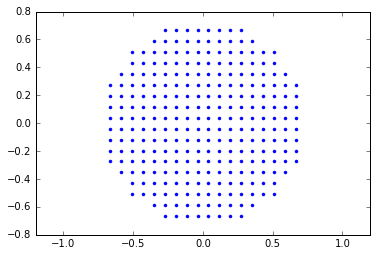

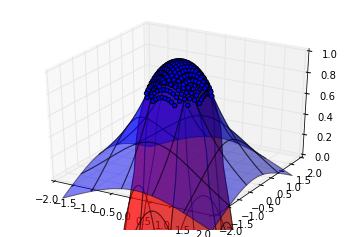

In [206]:
Alpha = .68026
Beta = .47152
f = lambda x,y: x*0
f2 = lambda: x,y: -Alpha*np.log(np.sqrt(x**2 + y**2)) + Beta
psi = lambda x,y: np.sqrt(np.maximum(0.0,1 - x**2 - y**2)) + np.minimum(0.0,1-x**2-y**2)

m = 50
h = 1/(m+1)
N = m**2
X, U = reducedspace2(psi,m,f,f2)

In [ ]:
A,B = np.meshgrid(X,X)
C = psi(A,B)
Z = np.zeros((m,m))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            x.append(-2.0 + 4*h*(i+1))
            y.append(-2.0 + 4*h*(j+1))
            z.append(Z[i,j])
plt.plot(x,y,'.')
plt.axis('equal')
N = m**2

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
C = psi(A,B)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf1 = ax.plot_surface(A,B,C,color = 'r',vmin = 0.0, vmax = 5.1, alpha = .5)
surf2 = ax.plot_surface(A,B,Z,vmin = 0.0, vmax = 5.1, alpha = .5)
scatter1 = ax.scatter(np.array(x),np.array(y),z,vmin = 0.0, vmax = 5.1, alpha = 1, color = 'k')
ax.set_zlim3d(0,1)
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)

norm = [ 0.00111006] 1234
0.713130638761
0.737650203383
0.720971620033
0.725390421072


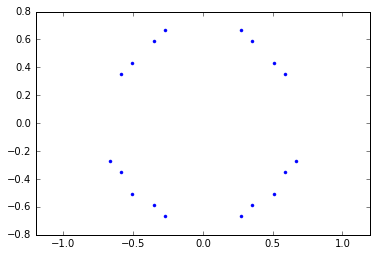

In [213]:
A,B = np.meshgrid(X,X)
C = psi(A,B)
Z = np.zeros((m,m))
uexact = np.zeros((N,1))
kk = lambda i,j: j * m + i
for j in range(m):
    for i in range(m):
        Z[i,j] = U[kk(i,j)]
        if r > .69797:
            uexact[kk(i,j)] = f2(X[i],X[j])
        else:
            uexact[kk(i,j)] = psi(X[i],X[j])
print('||U - uexact||_inf =',max(list(abs(uexact - U))),np.argmax(list(abs(uexact - U))))

x = []
y = []
z = []
for j in range(0,m):
    for i in range(0,m):
        if abs(Z[i,j] - C[i,j]) < 10**-6:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
    
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    rmax = max(normlist)
    return x1, y1, z1, A, rmax

x1, y1, z1, A1, rmax = area(x,y,z,m)
plt.plot(x1,y1,'.')
plt.axis('equal') 

x = []
y = []
z = []
for j in range(0,m-1):
    for i in range(0,m-1):
        if abs(Z[i,j] - C[i,j]) < 10**-2:
            if np.linalg.norm(np.array([-2.0 + 4*h*(i+1),-2.0 + 4*h*(j+1)])) <= 2:
                x.append(-2.0 + 4*h*(i+1))
                y.append(-2.0 + 4*h*(j+1))
                z.append(Z[i,j])
#plt.plot(x,y,'.')
#plt.axis('equal') 
def area(x,y,z,m):
    x1 = [x[0]]
    y1 = [y[0]]
    z1 = [z[0]]
    firstrow = False
    firstinrow = 0
    for i in range(len(x)):
        if i > 0 and y[i] > y[i-1] and firstrow == False and x[i] != x[i - 2]:
            firstinrow = i
            x1.append(x[i - 1])
            y1.append(y[i - 1])
            z1.append(z[i - 1])
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
        if i == len(x) - 1:
            x1.append(x[i])
            y1.append(y[i])
            z1.append(z[i])
    A = 0
    h = 1/(m+1)
    
    b1 = x1[1] - x1[0]
    for j in range(2,len(x1),2):
        b2 = x1[j+1] - x1[j]
        h1 = y1[j] - y1[j - 1]
        A += h1*(b1 + b2)/2
        b1 = b2
    j = 0
    while j < len(x1):
        if j > 1 and abs(x1[j] - x1[j-2]) < 10**-10 and j < len(x1) - 2:
            x1 = x1[0:j] + x1[j+2:len(x1)]
            y1 = y1[0:j] + y1[j+2:len(y1)]
            j -= 1
        j += 1
        
    normlist = [np.linalg.norm(np.array([x1[i],y1[i]])) for i in range(0,len(x1))]
    rmax = max(normlist)
    return x1, y1, z1, A, rmax
x2, y2, z2, A2, rmax2 = area(x,y,z,m)
a = np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)])
b = np.mean([rmax,rmax2])
print(np.mean([np.sqrt(A1/np.pi),np.sqrt(A2/np.pi)]))
print(np.mean([rmax,rmax2]))
print(rmax)
print(np.mean([a,b]))

In [ ]:
'''
Original finite difference scheme for 2D obstacle problem. Discretizes the first derivative as a matrix A using 
forward differences to produce bidiagonal matrix. The integral over [-1,1] of the gradient norm is then approximated 
by the product U^T*A^T*A*U, where U represents an unknown discrization to u(x), the solution to the obstacle problem.
After computing A, U can be solved for using a quadratic program, for example. This approach is extremely inefficient, 
as it uses twice as much memory as the Poisson matrix does. 
'''
def obstacle2D(psi, m, f):
    N = m**2
    h = 1/(m+1)
    X = np.linspace(-2.0 + 4*h,2.0 - 4*h,m)
    A = np.zeros((2*N + 2*m,2*N))
    F = np.zeros((2*N,1))
    P = np.zeros((2*N,1))
    Uk = np.zeros((2*N,1))
    B = np.zeros((N,2*N))
    T = np.zeros((m+1,m))
    T[0,0] = 1.0
    T[m,m-1] = -1.0
    for i in range(1,m):
        T[i,i-1] = -1.0
        T[i,i] = 1.0
    for i in range(0,2*m):
        A[i*(m+1):(i+1)*(m+1),i*m:(i+1)*m] = T
    A = A/h**2
    print(A)
    A = np.dot(np.transpose(A),A)
    for i in range(0,m):
        for j in range(0,m):
            B[i*m + j,i + j*m] = 1.0
    B[0:N,N:2*N] = -np.identity(N)
    kk = lambda i,j: j * m + i
    for j in range(0,m):
        for i in range(0,m):
            k = kk(i,j)
            F[k] = f(X[i],X[j])
            F[k + N] = f(X[j],X[i])
            P[k] = psi(X[i],X[j])
            P[k + N] = psi(X[j],X[i])
            Uk[k] = max(P[k],0.0)
            Uk[k + N] = max(P[k + N],0.0)
    print(B)
    return A, B, Uk, P, F, X
